In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from heatmap_grammar import Plot, Heatmap, RowAnnotation, ColumnAnnotation, markdown

In [3]:
import pandas as pd
import numpy as np

## Colors

In [4]:
mat = pd.read_csv('data/random.csv', index_col=0)
mat.iloc[:3, :3]

,column1,column2,column3
row1,0.904742,-0.352298,0.501610
row2,0.908830,0.791571,1.072632
row3,0.280747,0.029875,0.705259


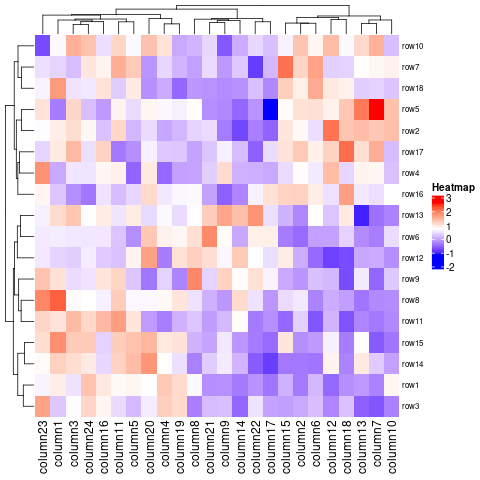

In [5]:
(
    Plot()
    + Heatmap(mat)
)

The default colour scheme differs from `ComplexHeatmap`:
- it does not automatically scale to quantiles,
- it does not enforce symmetrical range.

The `ComplexHeatmap`'s default can be reproduced as follows:

In [6]:
from heatmap_grammar import scale_fill_gradient2

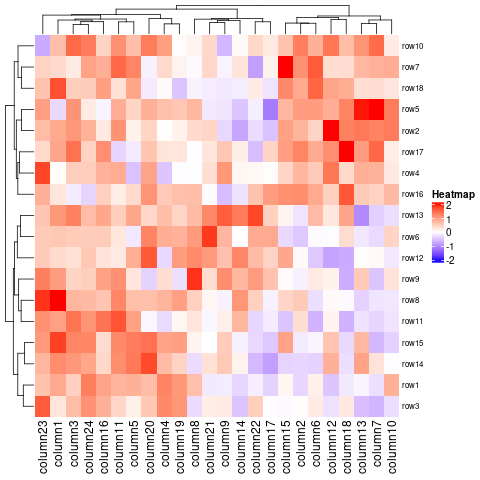

In [7]:
(
    Plot()
    + (
        Heatmap(mat)
        + scale_fill_gradient2(quantiles=[0.01, 0.99], symmetrical=True)
    )
)

In general, colours are managed by ggplot-style scales, for example to set NA colour, use `na_value` (note: with underscore, not `na.value`):

In [8]:
np.random.seed(0)
mat_with_na = mat.mask(np.random.random(mat.shape) < .1)

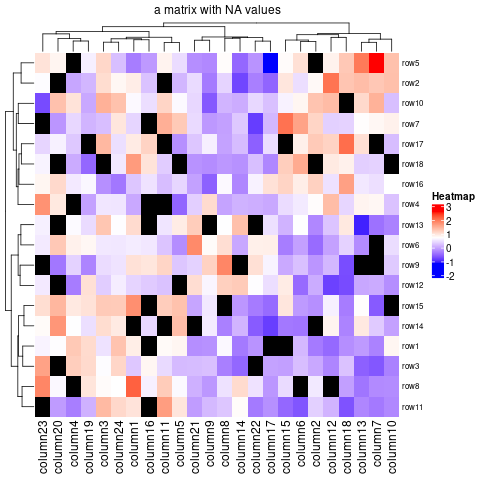

In [9]:
(
    Plot()
    + (
        Heatmap(
            mat_with_na,
            title='a matrix with NA values'
        )
        + scale_fill_gradient2(na_value='black')
    )
)

### Custom distance functions

In [10]:
mat_with_outliers = mat.copy()
for i in range(10):
    mat_with_outliers.iloc[i, i] = 1000

In [11]:
from heatmap_grammar import clustering_distance, scale_fill_gradient_n, HeatmapTheme

In [12]:
from sklearn.metrics.pairwise import nan_euclidean_distances

In [13]:
@clustering_distance
def robust_dist(data: pd.DataFrame):
    low = data.quantile(0.1)
    high = data.quantile(0.9)
    is_deemed_outlier = (data < low) | (data > high)
    without_outliers = data.mask(is_deemed_outlier)
    return pd.DataFrame(nan_euclidean_distances(without_outliers))

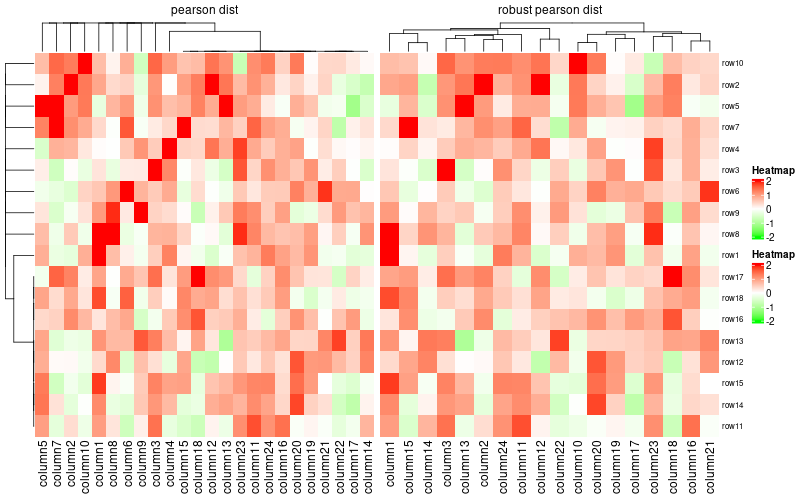

In [14]:
robust_scale = scale_fill_gradient_n(
    colors=['green', 'white', 'red'],
    points=[-2, 0, 2],
    quantiles=[0.01, 0.95],
    symmetrical=True
)
(
    Plot().size(w=800, h=500)
    + (
        Heatmap(
            mat_with_outliers,
            title='pearson dist'
        )
        + robust_scale
    )
    + (
        Heatmap(
            mat_with_outliers,
            clustering_distance_rows=robust_dist,
            clustering_distance_columns=robust_dist,
            title='robust pearson dist'
        )
        + robust_scale
    )
)

In [15]:
@clustering_distance
def robust_pearson_dist(data: pd.DataFrame):
    low = data.quantile(0.1)
    high = data.quantile(0.9)
    is_deemed_outlier = (data < low) | (data > high)
    without_outliers = data.mask(is_deemed_outlier)
    return 1 - without_outliers.corr(method='pearson')

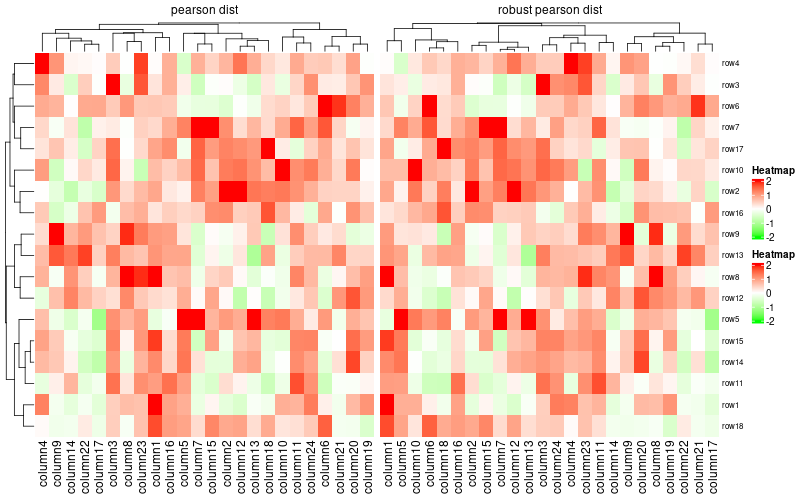

In [16]:
(
    Plot().size(w=800, h=500)
    + (
        Heatmap(
            mat_with_outliers,
            clustering_distance_rows='pearson',
            clustering_distance_columns='pearson',
            title='pearson dist'
        )
        + robust_scale
    )
    + (
        Heatmap(
            mat_with_outliers,
            clustering_distance_rows=robust_pearson_dist,
            clustering_distance_columns=robust_pearson_dist,
            title='robust pearson dist'
        )
        + robust_scale
    )
)

# More Examples

Example "14.3 Visualize Cell Heterogeneity from Single Cell RNASeq" from https://jokergoo.github.io/ComplexHeatmap-reference/book/more-examples.html

In [17]:
expr = pd.read_table('mouse_scRNAseq_corrected.txt', index_col=0)
expr.iloc[:3, :3]

,Cell 1,Cell 2,Cell 3
Gnai3,3.23220,1.98320,2.2482
Cdc45,3.19810,1.17300,3.1705
Narf,0.29411,0.49389,1.6279


In [18]:
len(expr)

7073

Drop duplicate genes:

In [19]:
expr = expr[~expr.index.duplicated(keep='first')]
len(expr)

7071

In [20]:
expr = expr[(expr > 0).mean(axis=1) > 0.5]
len(expr)

6092

Extract "signature" genes:

In [21]:
def get_correlated_variable_genes(data, cor_cutoff=0.5, n_cutoff=20):
    dt = expr.T.corr(method='spearman')
    np.fill_diagonal(dt.values, 0)
    dt[dt.abs() < cor_cutoff] = 0
    dt[dt < 0] = -1
    dt[dt > 0] = 1
    should_keep = dt.abs().sum() > n_cutoff
    return expr[should_keep]

In [22]:
mat = get_correlated_variable_genes(expr)

In [23]:
from scipy.stats import zscore

In [24]:
def trim_and_scale(df):
    df = df.copy()
    q10 = df.quantile(0.1, axis=1)
    q90 = df.quantile(0.9, axis=1)
    return (
        df.T
        .mask(df.T < q10, other=q10, axis=1)
        .mask(df.T > q90, other=q90, axis=1)
        .T
        .apply(zscore, axis=1)
    )

In [25]:
mat2 = trim_and_scale(mat)

In [26]:
cc = pd.read_csv('data/mouse_cell_cycle_gene.csv', index_col=0).squeeze()
rp = pd.read_csv('data/mouse_ribonucleoprotein.csv', index_col=0).squeeze()

In [27]:
from heatmap_grammar import scale_fill_manual, RowAnnotation, Annotation, HeatmapTheme

In [28]:
base_mean = mat.mean(axis=1).rename('base expr')

In [29]:
rpl = pd.Series(
    mat.index.isin(rp),
    index=mat.index,
    name='ribonucleoprotein'
)

In [30]:
ccl = pd.Series(
    mat.index.isin(cc),
    index=mat.index,
    name='cell cycle'
)

In [31]:
names_to_highlight = (
    (ccl & (base_mean > base_mean.quantile(0.25)))
    .to_frame('should_annotate')
    .assign(gene=lambda df: df.index)
)
names_to_highlight.head(3)

,should_annotate,gene
Sdhd,False,Sdhd
Ccnd2,True,Ccnd2
Dazap2,False,Dazap2


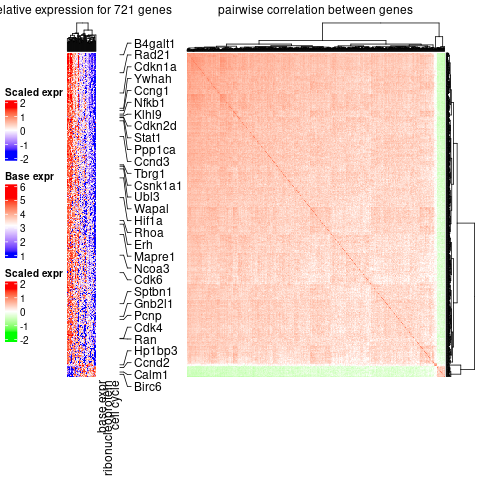

In [57]:
(
    Plot()
    + (
        Heatmap(
            mat2,
            title=f'relative expression for {len(mat)} genes',
            show_column_names=False,
            show_row_names=False,
            # width=Unit(8, 'cm'),
        )
        + scale_fill_gradient_n(
            colors=['blue', 'white', 'red'],
            points=[-1.5, 0, 1.6],
            name='Scaled expr',
        )
    )
    + (
        Heatmap(
            base_mean,
            show_row_names=False,
            #width = unit(5, "mm"),
        )
        + scale_fill_gradient_n(
            colors=['blue', 'white', 'red'],
            name='Base expr'
        )
    )
    + (
        Heatmap(
            rpl + 0,
            show_row_names=False
        )
        + scale_fill_manual(
            values={'0': 'white', '1': 'purple'},
            guide='none'
        )
    )
    + (
        Heatmap(
            ccl + 0,
            show_row_names=False
        )
        + scale_fill_manual(
            values={'0': 'white', '1': 'red'},
            guide='none'
        )
    )
    + (
        RowAnnotation(names_to_highlight)
        + Annotation(
            geom='mark',
            mapping=dict(
                value='should_annotate',
                label='gene'
            )
        )
    )
    + (
        Heatmap(
            mat2.T.corr(),
            title='pairwise correlation between genes',
            show_column_names=False,
            show_row_names=False,
            row_dend_side='right',
            name='cor'
            # width=Unit(8, 'cm'),
        )
        + scale_fill_gradient_n(
            colors=['green', 'white', 'red'],
            points=[-1.5, 0, 1.6],
            name='Scaled expr',
        )
    )
    + HeatmapTheme(
        main_heatmap='cor'
    )
)